In [443]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import timedelta
from typing import override

In [122]:
class Generator:
    name: str
    base_cost: float
    base_generation: float
    cost_scaling: float
    count: int
    researches: list
    
    def __init__(self, name: float, base_cost: float, base_generation: float, cost_scaling: float):
        self.name = name
        self.base_cost = base_cost
        self.base_generation = base_generation
        self.cost_scaling = cost_scaling
        self.count = 0
        self.researches = []
    
    def reset(self):
        self.count = 0
        self.researches = []
    
    def get_cost(self):
        multiplier = 1.0
        for research in self.researches:
            multiplier *= 1.0 - research.base_cost_decrease
        
        scaling = 1.0
        for research in self.researches:
            scaling *= 1.0 - research.base_scaling_decrease
            
        return self.base_cost * self.cost_scaling ** (scaling * self.count) * multiplier
    
    def get_generation(self):
        multiplier = 1.0
        for research in self.researches:
            multiplier *= 1.0 + research.base_generation_increase
            
        return self.base_generation * self.count * multiplier

    def can_buy(self, energy: float):
        return energy >= self.get_cost()


In [123]:
class Research:
    researched: bool
    cost: float
    
    def __init__(self, cost: float):
        self.cost = cost
        self.researched = False
    
    def reset(self):
        self.researched = False
    
    def can_buy(self, research_point: float):
        return research_point >= self.cost and not self.researched


In [1217]:
class GeneratorResearch(Research):
    generator: Generator
    base_cost_decrease: float
    base_generation_increase: float
    base_scaling_decrease: float
    
    def __init__(self, generator: Generator, cost: float,
                 base_cost_decrease: float, base_generation_increase: float,
                 base_scaling_decrease: float = 0.0):    
        super().__init__(cost)
        
        self.generator = generator
        
        self.base_cost_decrease = base_cost_decrease
        self.base_generation_increase = base_generation_increase
        self.base_scaling_decrease = base_scaling_decrease

        self.researched = False
    
    @override
    def can_buy(self, research_point: float):
        return research_point >= self.cost and self.generator.count > 0 and not self.researched
    

In [1218]:
class MetaResearch(Research):
    efficiency_increase: float
    
    def __init__(self, cost: float, efficiency_increase: float):
        super().__init__(cost)
        self.efficiency_increase = efficiency_increase
        

In [1440]:
class Game:
    generators: list
    researches: list
    
    prestige: int
    energy: float
    research_points: float
    research_ratio: float
    speed_scaling: float
    
    time_since_last_prestige: float
    
    meta_researches: list[MetaResearch]
    
    def __init__(self):
        
        self.speed_scaling = 1.5
        
        gen_HumanPower     = Generator("HumanPower",     1e3 ,   1e2 ,   1.25)
        gen_Campfire       = Generator("Campfire",       1e4 ,   1e3 ,   1.25)
        gen_Watermill      = Generator("Watermill",      1e5 ,   1e4 ,   1.5 )
        gen_Charcoal       = Generator("Charcoal",       1e6 ,   1e5 ,   1.5 )
        gen_FossilSteam    = Generator("FossilSteam",    1e8 ,   1e6 ,   2.0 )
        gen_FossilElectric = Generator("FossilElectric", 1e9 ,   1e7 ,   2.0 )
        gen_Solar          = Generator("Solar",          1e11,   1e8 ,   3.0 )
        gen_Fission        = Generator("Fission",        1e13,   1e9 ,   3.0 )
        gen_Fusion         = Generator("Fusion",         1e15,   1e10,   4.0 )
        gen_DysonSwarm     = Generator("DysonSwarm",     1e18,   1e16,   6.0 )
        gen_BlackHole      = Generator("BlackHole",      1e26,   1e24,   8.0 )
        gen_VacuumEnergy   = Generator("VacuumEnergy",   1e36,   1e34,  10.0 )

        self.generators = [
            gen_HumanPower,
            gen_Campfire,
            gen_Watermill,
            gen_Charcoal,
            gen_FossilSteam,
            gen_FossilElectric,
            gen_Solar,
            gen_Fission,
            gen_Fusion,
            gen_DysonSwarm,
            gen_BlackHole,
            gen_VacuumEnergy,
        ]
        
        researches_list = [
            [GeneratorResearch(gen_HumanPower,     1e3 * 2 ** i, 0.25, 0.0) for i in range(4)],
            [GeneratorResearch(gen_HumanPower,     1e3 * 2 ** i, 0.0, 0.25) for i in range(4)],
            
            [GeneratorResearch(gen_Campfire,       1e4 * 2 ** i, 0.25, 0.0) for i in range(4)],
            [GeneratorResearch(gen_Campfire,       1e4 * 2 ** i, 0.0, 0.25) for i in range(4)],
            
            [GeneratorResearch(gen_Watermill,      1e5 * 2 ** i, 0.25, 0.0) for i in range(4)],
            [GeneratorResearch(gen_Watermill,      1e5 * 2 ** i, 0.0, 0.25) for i in range(4)],
            
            [GeneratorResearch(gen_Charcoal,       1e6 * 2 ** i, 0.25, 0.0) for i in range(4)],
            [GeneratorResearch(gen_Charcoal,       1e6 * 2 ** i, 0.0, 0.5) for i in range(4)],
            
            [GeneratorResearch(gen_FossilSteam,    1e8 * 2 ** i, 0.25, 0.0) for i in range(4)],
            [GeneratorResearch(gen_FossilSteam,    1e8 * 2 ** i, 0.0, 0.75) for i in range(4)],
            
            [GeneratorResearch(gen_FossilElectric, 1e9 * 2 ** i, 0.25, 0.0) for i in range(4)],
            [GeneratorResearch(gen_FossilElectric, 1e9 * 2 ** i, 0.0, 1.0) for i in range(4)],
            
            [GeneratorResearch(gen_Solar,       1e11 * 2 ** i, 0.5, 0.0) for i in range(12)],
            [GeneratorResearch(gen_Solar,       1e11 * 2 ** i, 0.0, 0.5) for i in range(8)],
            [GeneratorResearch(gen_Solar,       1e11 * 2 ** i, 0.0, 0.0, 0.5) for i in range(10)],
            
            [GeneratorResearch(gen_Fission,     1e13 * 2 ** i, 0.5, 0.0) for i in range(8)],
            [GeneratorResearch(gen_Fission,     1e13 * 2 ** i, 0.0, 1.0) for i in range(8)],
            [GeneratorResearch(gen_Fission,     1e13 * 2 ** i, 0.0, 0.0, 0.25) for i in range(10)],
            
            [GeneratorResearch(gen_Fusion,      1e16 * 2 ** i, 0.5, 0.0) for i in range(8)],
            [GeneratorResearch(gen_Fusion,      1e16 * 2 ** i, 0.0, 1.0) for i in range(8)],
            [GeneratorResearch(gen_Fusion,      1e16 * 2 ** i, 0.0, 0.0, 0.25) for i in range(10)],
            
            [GeneratorResearch(gen_DysonSwarm,  1e22 * 2 ** i, 0.5, 0.0) for i in range(12)],
            [GeneratorResearch(gen_DysonSwarm,  1e22 * 2 ** i, 0.0, 0.5) for i in range(8)],
            [GeneratorResearch(gen_DysonSwarm,  1e22 * 2 ** i, 0.0, 0.0, 0.5) for i in range(10)],
            
            [GeneratorResearch(gen_BlackHole,   1e34 * 2 ** i, 0.5, 0.0) for i in range(12)],
            [GeneratorResearch(gen_BlackHole,   1e34 * 2 ** i, 0.0, 1.0) for i in range(12)],
            [GeneratorResearch(gen_BlackHole,   1e34 * 2 ** i, 0.0, 0.0, 0.25) for i in range(12)],
            
            [GeneratorResearch(gen_Fusion,      1e45 * 2 ** i, 0.5, 0.0) for i in range(12)],
            [GeneratorResearch(gen_Fusion,      1e45 * 2 ** i, 0.0, 1.0) for i in range(12)],
            [GeneratorResearch(gen_Fusion,      1e45 * 2 ** i, 0.0, 0.0, 0.25) for i in range(12)],
            
            [MetaResearch(1e2 * 10 ** i, 0.5) for i in range(10)],
            [MetaResearch(1e5 * 10 ** (2 * i), 1.0) for i in range(5)],
            [MetaResearch(1e13 * 10 ** (3 * i), 1.0) for i in range(5)],
            [MetaResearch(1e22 * 10 ** (4 * i), 2.0) for i in range(5)],
        ]
        
        self.researches = [x for xs in researches_list for x in xs]
        self.meta_researches = [x for x in self.researches if isinstance(x, MetaResearch)]
        
        self.prestige = 0
        self.research_ratio = 0.0
        
        self.time_since_last_prestige = 0.0
        
        self.reset_layer_1()
    
    
    def reset_layer_1(self):
        self.energy = 1000.0
        self.research_points = 0.0
        
        for generator in self.generators:
            generator.reset()
        
        for research in self.researches:
            research.reset()

    
    def step(self, t: float, dt: float):
        start_prestige = self.prestige
        
        self.buy_prestige()
        
        if self.prestige > start_prestige:
            print(f"> prestiged at {timedelta(seconds=int(t))}")
            print(f"  duration is {int(t - self.time_since_last_prestige) // 60} mins")
            self.time_since_last_prestige = t
        
        self.buy_all_researches()
        
        if self.energy <= self.get_prestige_cost() * 0.4:
            if t % 10 > 8:
                self.buy_all_generators()
            self.research_ratio = 0.2
        else:
            self.research_ratio = 0.0
            
        self.generate_resources(dt)


    def buy_all_generators(self):
        bought = 0
        for generator in reversed(self.generators):
            if generator.count > 0:
                bought += 1
                
            if bought >= 3:
                break
            
            iter = 0
            while generator.can_buy(self.energy) and iter < 100:
                self.buy_generator(generator)
                iter += 1
    
    def buy_generator(self, generator: Generator):
        if generator.can_buy(self.energy):
            self.energy -= generator.get_cost()
            generator.count += 1
            
            
    def buy_all_researches(self):
        for research in reversed(self.researches):
            self.buy_research(research)
                
    def buy_research(self, research: Research):
        if research.can_buy(self.research_points):
            self.research_points -= research.cost
            research.researched = True
            
            if isinstance(research, GeneratorResearch):
                research.generator.researches.append(research)
    
    
    def generate_resources(self, dt: float):
        for generator in self.generators:
            generation = generator.get_generation() * self.get_prestige_speed() * dt
            self.energy += generation * (1.0 - self.research_ratio)
            self.research_points += generation * self.research_ratio * self.get_research_per_energy()

    
    def get_research_per_energy(self):
        result = 0.001
        for research in self.meta_researches:
            if research.researched:
                result *= 1.0 + research.efficiency_increase
            
        return result
    
    def get_prestige_speed(self):
        return self.speed_scaling ** self.prestige
    
    def get_prestige_cost(self):
        # num = np.floor(self.prestige / 10.0)
        # exponent = (1 + num) * self.prestige
        exponent = self.prestige
        
        return 1e5 * 10.0 ** exponent
    
    def buy_prestige(self):
        if self.energy >= self.get_prestige_cost():
            self.prestige += 1
            self.reset_layer_1()
        # success = False
        # while self.energy >= self.get_prestige_cost():
        #     self.prestige += 1
        #     success = True
            
        # if success:
        #     self.reset_layer_1()


In [1441]:
game = Game()

t: float = 0
dt: float = 0.05
num_step: int = 0

energy_by_time = []
research_by_time = []
prestige_cost_by_time = []
generator_count_by_time = { generator.name: [] for generator in game.generators }
generator_generation_by_time = { generator.name: [] for generator in game.generators }
t_by_time = []

while t <= 3 * 60 * 60:
    if num_step % 1 == 0:
        energy_by_time.append(game.energy)
        research_by_time.append(game.research_points)
        prestige_cost_by_time.append(game.get_prestige_cost())
        for generator in game.generators:
            generator_count_by_time[generator.name].append(generator.count)
            generator_generation_by_time[generator.name].append(generator.get_generation())
        t_by_time.append(t)
    
    game.step(t, dt)
    
    t += dt
    num_step += 1

> prestiged at 0:02:29
  duration is 2 mins
> prestiged at 0:05:15
  duration is 2 mins
> prestiged at 0:07:54
  duration is 2 mins
> prestiged at 0:11:12
  duration is 3 mins
> prestiged at 0:16:24
  duration is 5 mins
> prestiged at 0:22:09
  duration is 5 mins
> prestiged at 0:29:22
  duration is 7 mins
> prestiged at 0:36:24
  duration is 7 mins
> prestiged at 0:44:06
  duration is 7 mins
> prestiged at 0:49:47
  duration is 5 mins
> prestiged at 0:53:52
  duration is 4 mins
> prestiged at 0:57:00
  duration is 3 mins
> prestiged at 0:59:57
  duration is 2 mins
> prestiged at 1:06:49
  duration is 6 mins
> prestiged at 1:13:13
  duration is 6 mins
> prestiged at 1:17:22
  duration is 4 mins
> prestiged at 1:23:48
  duration is 6 mins
> prestiged at 1:28:38
  duration is 4 mins
> prestiged at 1:32:04
  duration is 3 mins
> prestiged at 1:34:30
  duration is 2 mins
> prestiged at 1:36:21
  duration is 1 mins
> prestiged at 1:38:00
  duration is 1 mins
> prestiged at 1:39:28
  duratio

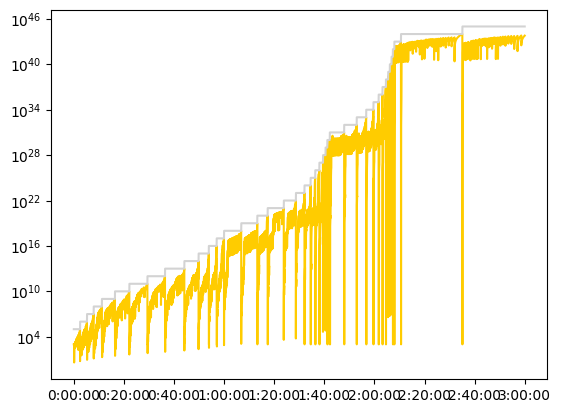

In [1442]:
fig, ax = plt.subplots()
ax.plot(t_by_time, energy_by_time, c="#ffcc00")
ax.plot(t_by_time, prestige_cost_by_time, c="lightgray")

ax.set_yscale("log")
_, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 20 * 60))
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: str(timedelta(seconds=int(x))))
)

plt.show()

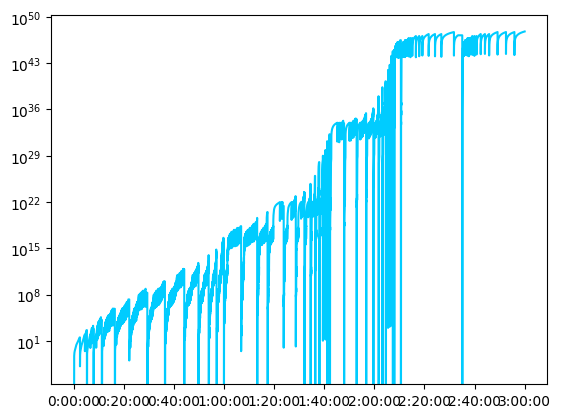

In [1443]:
fig, ax = plt.subplots()
ax.plot(t_by_time, research_by_time, c="#00ccff")

ax.set_yscale("log")
_, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 20 * 60))
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: str(timedelta(seconds=int(x))))
)

plt.show()

In [1444]:
colors = [
    "#D3B993",  # HumanPower
    "#ed501b",  # Campfire
    "#3787ff",  # Watermill
    "#3C3C3C",  # Charcoal
    "#47371C",  # FossilSteam
    "#705826",  # FossilElectric
    "#4dd8f0",  # Solar
    "#395C24",  # Fission
    "#CD37CA",  # Fusion
    "#FBC155",  # DysonSwarm
    "#000000",  # BlackHole
    "#5625b7",  # VacuumEnergy
]

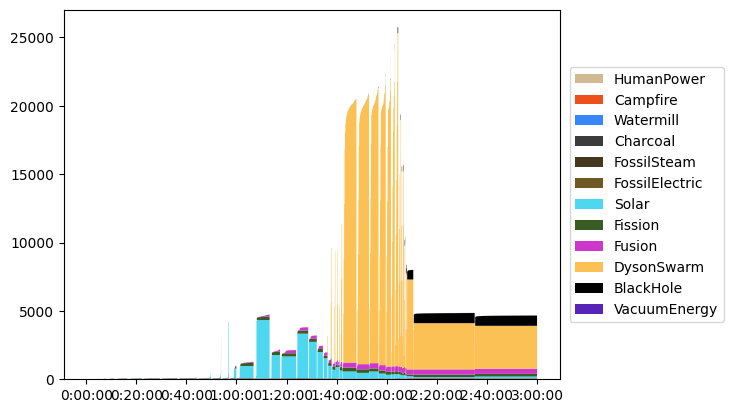

In [1445]:
fig, ax = plt.subplots()

labels = list(generator_count_by_time.keys())
values = list(generator_count_by_time.values())

ax.stackplot(t_by_time, values, labels=labels, colors=colors)
_, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 20 * 60))
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: str(timedelta(seconds=int(x))))
)

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.show()

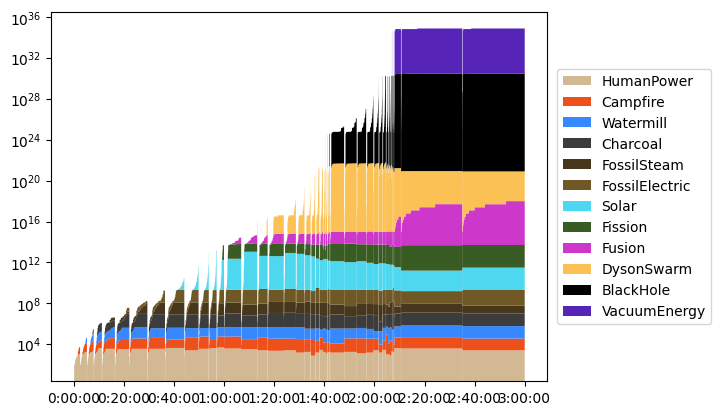

In [1446]:
fig, ax = plt.subplots()

labels = list(generator_generation_by_time.keys())
values = list(generator_generation_by_time.values())

ax.stackplot(t_by_time, values, labels=labels, colors=colors)
_, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 20 * 60))
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: str(timedelta(seconds=int(x))))
)
ax.set_yscale("log")

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.show()